
<h3>objetivo: prever o número de bicicletas alugadas no futuro</h3>

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# importando layers e models específicos para facil utilização
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU

In [2]:
bike = pd.read_csv('./data/bicicletas.csv')

## visualização geral dos dados

In [3]:
bike.head()

,datas,contagem,temperatura,sensacao,umidade,vel_vento,clima,feriado,final_ds,estacao
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


- precisamos converter essa data para utilizar

In [5]:
bike['datas'] = pd.to_datetime(bike['datas'])
bike.head()

,datas,contagem,temperatura,sensacao,umidade,vel_vento,clima,feriado,final_ds,estacao
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


(array([16436., 16526., 16617., 16709., 16801., 16892., 16983., 17075.,
        17167.]),
 [Text(16436.0, 0, '2015-01'),
  Text(16526.0, 0, '2015-04'),
  Text(16617.0, 0, '2015-07'),
  Text(16709.0, 0, '2015-10'),
  Text(16801.0, 0, '2016-01'),
  Text(16892.0, 0, '2016-04'),
  Text(16983.0, 0, '2016-07'),
  Text(17075.0, 0, '2016-10'),
  Text(17167.0, 0, '2017-01')])

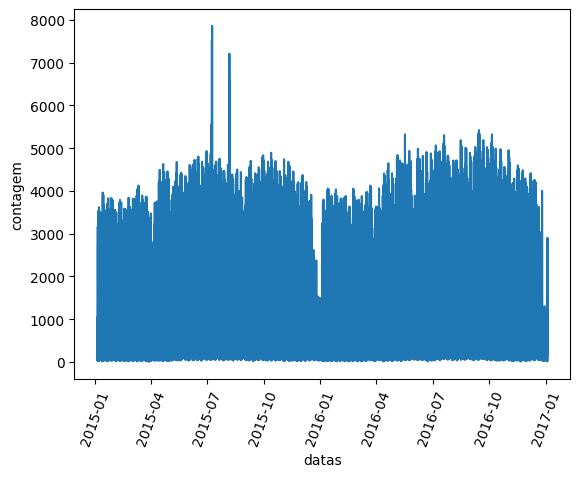

In [7]:
sns.lineplot(x='datas',y='contagem', data=bike)
plt.xticks(rotation=70)

### escalonando dados

In [9]:

sc = StandardScaler()
sc.fit(bike['contagem'].values.reshape(-1,1)) # valores entre -1 e 1

StandardScaler()

In [10]:
y = sc.transform(bike['contagem'].values.reshape(-1,1))

## dividindo entre treino e teste

In [11]:
tamanho_treino = int(len(bike)*0.9) #Pegando 90% dos dados para treino
tamanho_teste = len(bike)-tamanho_treino # O resto vamos reservar para teste

In [12]:
ytreino = y[0:tamanho_treino]
yteste = y[tamanho_treino:len(bike)]

(array([16436., 16526., 16617., 16709., 16801., 16892., 16983., 17075.,
        17167.]),
 [Text(16436.0, 0, '2015-01'),
  Text(16526.0, 0, '2015-04'),
  Text(16617.0, 0, '2015-07'),
  Text(16709.0, 0, '2015-10'),
  Text(16801.0, 0, '2016-01'),
  Text(16892.0, 0, '2016-04'),
  Text(16983.0, 0, '2016-07'),
  Text(17075.0, 0, '2016-10'),
  Text(17167.0, 0, '2017-01')])

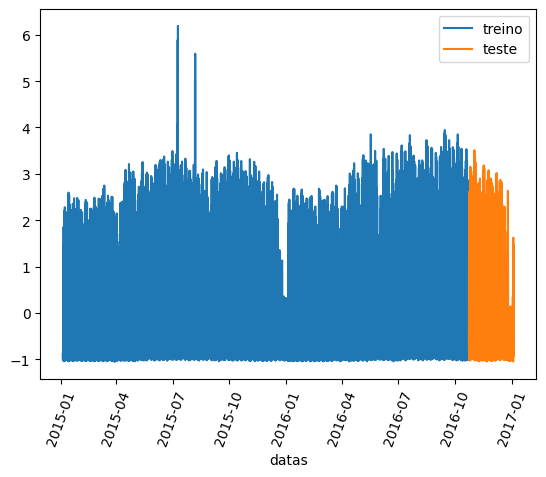

In [13]:
sns.lineplot(x='datas',y=ytreino[:,0],data=bike[0:tamanho_treino],label='treino') 
sns.lineplot(x='datas',y=yteste[:,0], data=bike[tamanho_treino:len(bike)],label='teste')
plt.xticks(rotation=70) 

In [18]:

# usando valor antigo para prever o próximo (n_passos = 1)
def separa_dados(vetor,n_passos):
    """Entrada: vetor: número de passageiros
            n_passos: número de passos no regressor
        Saída:
            X_novo: Array 2D 
            y_novo: Array 1D - Nosso alvo
    """
    
    X_novo, y_novo = [], []
    for i in range(n_passos,vetor.shape[0]):
        X_novo.append(list(vetor.loc[i-n_passos:i-1]))
        y_novo.append(vetor.loc[i])
    X_novo, y_novo = np.array(X_novo), np.array(y_novo) 
    return X_novo, y_novo

In [19]:
vetor_treino = pd.DataFrame(ytreino)[0]
vetor_teste = pd.DataFrame(yteste)[0]

In [20]:
xtreino_novo, ytreino_novo = separa_dados(vetor_treino, 10)
xteste_novo, yteste_novo = separa_dados(vetor_teste,10)

## montando rede neural

<h4>O que a LSTM (rede recorrente) espera</h4>

A entrada de redes recorrentes deve possuir a seguinte forma para a entrada (número de amostras, número de passos no tempo, e número de atributos por passo no tempo).

In [23]:
xtreino_novo = xtreino_novo.reshape((xtreino_novo.shape[0], xtreino_novo.shape[1], 1))
xteste_novo = xteste_novo.reshape((xteste_novo.shape[0], xteste_novo.shape[1], 1))

In [25]:
recorrente = Sequential()

In [26]:
recorrente.add(
    LSTM(
        # equivalente a ter 128 loops
        128, 

        # dimensão de entrada passo as duas ultimas dimensões da matriz de entrada
        input_shape=(xtreino_novo.shape[1], xtreino_novo.shape[2])
    )
)

# saída
recorrente.add(Dense(units=1))

In [28]:
recorrente.compile(loss='mean_squared_error',optimizer='RMSProp')
recorrente.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66689 (260.50 KB)
Trainable params: 66689 (260.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
resultado = recorrente.fit(xtreino_novo, ytreino_novo, validation_data=(xteste_novo, yteste_novo), epochs=100)

Epoch 1/100
490/490 [==============================] - 6s 12ms/step - loss: 0.2874 - val_loss: 0.0888
Epoch 2/100
490/490 [==============================] - 7s 14ms/step - loss: 0.0791 - val_loss: 0.0499
Epoch 3/100
490/490 [==============================] - 6s 13ms/step - loss: 0.0562 - val_loss: 0.0369
Epoch 4/100
490/490 [==============================] - 8s 15ms/step - loss: 0.0484 - val_loss: 0.0338
Epoch 5/100
490/490 [==============================] - 6s 11ms/step - loss: 0.0447 - val_loss: 0.0325
Epoch 6/100
490/490 [==============================] - 8s 15ms/step - loss: 0.0417 - val_loss: 0.0342
Epoch 7/100
490/490 [==============================] - 6s 11ms/step - loss: 0.0395 - val_loss: 0.0244
Epoch 8/100
490/490 [==============================] - 8s 16ms/step - loss: 0.0385 - val_loss: 0.0335
Epoch 9/100
490/490 [==============================] - 5s 11ms/step - loss: 0.0371 - val_loss: 0.0223
Epoch 10/100
490/490 [==============================] - 8s 16ms/step - loss: 0.035

## prevendo valores

In [31]:
y_ajustado = recorrente.predict(xtreino_novo)

490/490 [==============================] - 3s 4ms/step


(array([16436., 16526., 16617., 16709., 16801., 16892., 16983., 17075.]),
 [Text(16436.0, 0, '2015-01'),
  Text(16526.0, 0, '2015-04'),
  Text(16617.0, 0, '2015-07'),
  Text(16709.0, 0, '2015-10'),
  Text(16801.0, 0, '2016-01'),
  Text(16892.0, 0, '2016-04'),
  Text(16983.0, 0, '2016-07'),
  Text(17075.0, 0, '2016-10')])

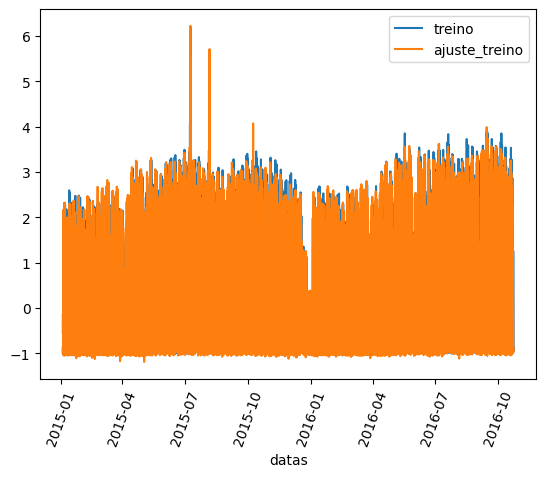

In [32]:
sns.lineplot(x='datas',y=ytreino[:,0],data=bike[0:tamanho_treino],label='treino')
sns.lineplot(x='datas',y=y_ajustado[:,0],data=bike[0:15662],label='ajuste_treino')
plt.xticks(rotation=70) 

In [33]:
y_predito = recorrente.predict(xteste_novo)

55/55 [==============================] - 0s 3ms/step


(array([17106., 17120., 17136., 17150., 17167.]),
 [Text(17106.0, 0, '2016-11-01'),
  Text(17120.0, 0, '2016-11-15'),
  Text(17136.0, 0, '2016-12-01'),
  Text(17150.0, 0, '2016-12-15'),
  Text(17167.0, 0, '2017-01-01')])

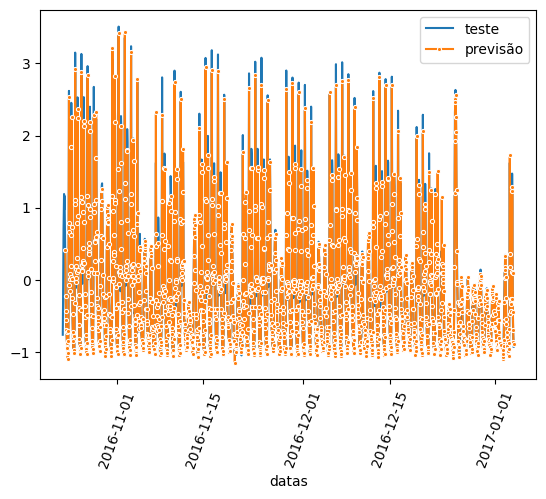

In [34]:
# comparando previsão com o teste
sns.lineplot(x='datas',y=yteste[:,0], data=bike[tamanho_treino:len(bike)],label='teste')
sns.lineplot(x='datas',y=y_predito[:,0], data=bike[tamanho_treino+10:len(bike)],marker='.',label='previsão')
plt.xticks(rotation=70) 

## utilizando GRU

In [36]:
recorrente_g = Sequential()

In [37]:
recorrente_g.add(GRU(128, input_shape=(xtreino_novo.shape[1],xtreino_novo.shape[2])))
recorrente_g.add(Dense(units=1))

In [38]:
recorrente_g.compile(loss='mean_squared_error',optimizer='RMSProp')
recorrente_g.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               50304     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 50433 (197.00 KB)
Trainable params: 50433 (197.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
resultado2 = recorrente_g.fit(xtreino_novo,ytreino_novo,validation_data=(xteste_novo,yteste_novo),epochs=100)

Epoch 1/100
490/490 [==============================] - 9s 13ms/step - loss: 0.2498 - val_loss: 0.0651
Epoch 2/100
490/490 [==============================] - 6s 12ms/step - loss: 0.0731 - val_loss: 0.0407
Epoch 3/100
490/490 [==============================] - 4s 9ms/step - loss: 0.0514 - val_loss: 0.0368
Epoch 4/100
490/490 [==============================] - 6s 12ms/step - loss: 0.0434 - val_loss: 0.0278
Epoch 5/100
490/490 [==============================] - 4s 8ms/step - loss: 0.0391 - val_loss: 0.0332
Epoch 6/100
490/490 [==============================] - 5s 10ms/step - loss: 0.0368 - val_loss: 0.0284
Epoch 7/100
490/490 [==============================] - 5s 11ms/step - loss: 0.0347 - val_loss: 0.0204
Epoch 8/100
490/490 [==============================] - 4s 8ms/step - loss: 0.0334 - val_loss: 0.0213
Epoch 9/100
490/490 [==============================] - 6s 12ms/step - loss: 0.0328 - val_loss: 0.0217
Epoch 10/100
490/490 [==============================] - 4s 9ms/step - loss: 0.0318 - 

In [40]:
y_predito_g = recorrente_g.predict(xteste_novo)

55/55 [==============================] - 1s 4ms/step


(array([17106., 17120., 17136., 17150., 17167.]),
 [Text(17106.0, 0, '2016-11-01'),
  Text(17120.0, 0, '2016-11-15'),
  Text(17136.0, 0, '2016-12-01'),
  Text(17150.0, 0, '2016-12-15'),
  Text(17167.0, 0, '2017-01-01')])

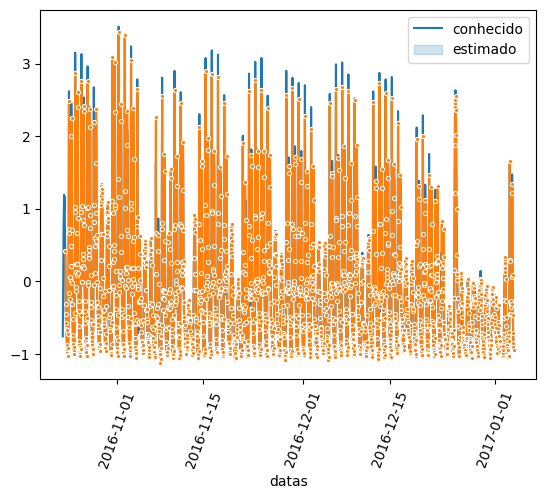

In [41]:
sns.lineplot(x='datas',y=yteste[:,0], data=bike[tamanho_treino:len(bike)])
sns.lineplot(x='datas',y=y_predito_g[:,0], data=bike[tamanho_treino+10:len(bike)],marker='.')
plt.legend(['conhecido','estimado'])
plt.xticks(rotation=70) 

Text(0.5, 1.0, 'treino e teste do LSTM')

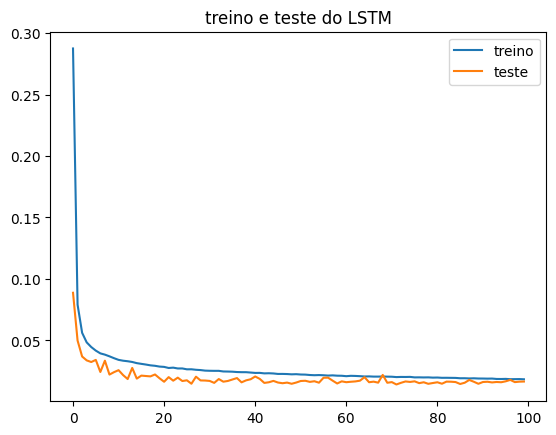

In [42]:
plt.plot(resultado.history['loss'])
plt.plot(resultado.history['val_loss'])
plt.legend(['treino','teste'])
plt.title('treino e teste do LSTM')

Text(0.5, 1.0, 'treino e teste do GRU')

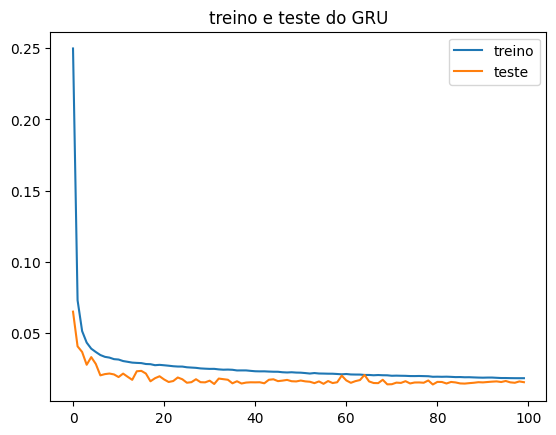

In [43]:
plt.plot(resultado2.history['loss'])
plt.plot(resultado2.history['val_loss'])
plt.legend(['treino','teste'])
plt.title('treino e teste do GRU')